<a href="https://colab.research.google.com/github/davivaug2/math4000_machine_learning_2023/blob/main/hmwk8_MATH4000_machine_learning_Vaughan_2023_03_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  David Vaughan  R1166390
# (MATH-4000-004)
# Homework 8 03/29/2023
#  Spring 2023 TTU Selected Topics: Machine learning model order reduction for differential equations (MATH-4000-004) Full Term: Homework for week  (due 03/29)

In [2]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 11.0 MB/s eta 0:00:00


In [1]:
%env DDE_BACKEND=pytorch

env: DDE_BACKEND=pytorch


### Problem 1

Read the code for solving ODE system in the lecture note. Modify it to solve the following ODE system for $0\le t \le 1$:
$$
\begin{aligned}
\frac{dx}{dt} &= x \\
\frac{dy}{dt} &= -x + 2y
\end{aligned}
$$
with the initial condition
$$
x(0) = -1, \quad y(0) = 1.
$$
In the figure, compare the neural network solution with the exact solution:
$$
x(t) = -e^t, \quad y(t) = -e^t + (2)*e^{2t}.
$$

Compiling model...
'compile' took 0.000392 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [3.08e-03, 1.88e-02, 1.00e+00, 1.00e+00]    [2.89e-03, 1.71e-02, 1.00e+00, 1.00e+00]    [1.02e+00]    
1000      [1.75e-02, 1.95e-01, 4.96e-02, 7.40e-02]    [1.63e-02, 1.66e-01, 4.96e-02, 7.40e-02]    [3.11e-01]    
2000      [1.40e-04, 2.72e-03, 9.52e-05, 2.00e-04]    [1.00e-04, 2.02e-03, 9.52e-05, 2.00e-04]    [1.36e-02]    
3000      [5.33e-05, 1.24e-03, 1.65e-05, 2.05e-05]    [5.25e-05, 9.63e-04, 1.65e-05, 2.05e-05]    [6.30e-03]    
4000      [5.05e-05, 1.93e-03, 2.80e-05, 3.33e-04]    [4.95e-05, 1.56e-03, 2.80e-05, 3.33e-04]    [4.75e-03]    
5000      [3.36e-05, 6.15e-04, 3.09e-06, 2.93e-06]    [3.34e-05, 5.03e-04, 3.09e-06, 2.93e-06]    [3.27e-03]    
6000      [1.20e-04, 7.39e-03, 2.51e-05, 1.25e-03]    [1.22e-04, 7.30e-03, 2.51e-05, 1.25e-03]    [3.44e-03]    
7000      [2.51e-05, 3.85e-04, 

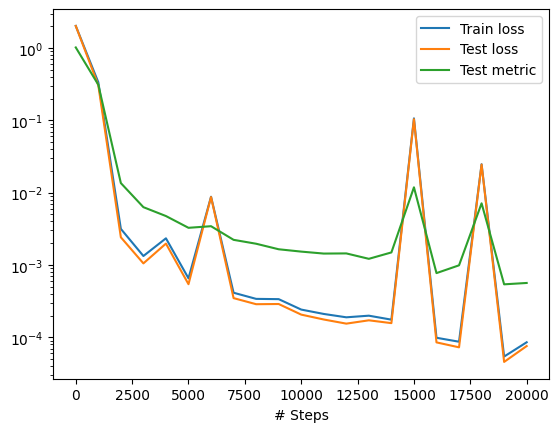

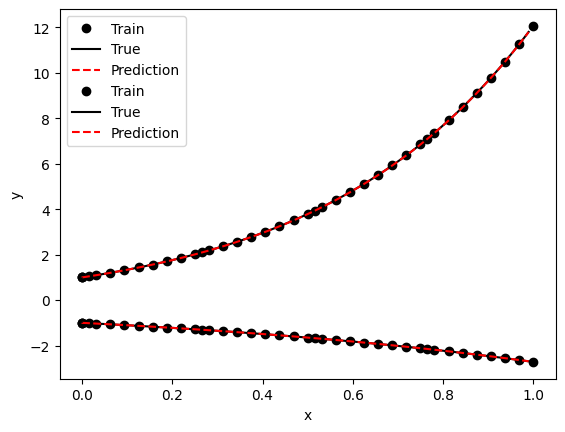

In [17]:
import deepxde as dde
import numpy as np

def ode_system(x_t, y_t):
  # previous ode
    """
    def ode_system(x, y):
      ODE system.
      dy1/dx = y2
      dy2/dx = -y1
      # the first dimension of y tensor is the training points
      # the second dimension o y tensor is the componets of the solution
      y1, y2 = y[:, 0:1], y[:, 1:]
      dy1_x = dde.grad.jacobian(y, x, i=0)
      dy2_x = dde.grad.jacobian(y, x, i=1)
      return [dy1_x - y2, dy2_x + y1]
    """
    # new
    """ODE system.
    dx/dt= x
    dy/dt = -x+2y
    """
    # the first dimension of y tensor is the training points
    # the second dimension o y tensor is the componets of the solution
    x, y = y_t[:, 0:1], y_t[:, 1:]
    dx_t = dde.grad.jacobian(y_t, x_t, i=0)
    dy_t = dde.grad.jacobian(y_t, x_t, i=1)
    return [dx_t - x, dy_t + (x-2*y)]


def boundary(_, on_initial):
    return on_initial
# 
def func(t):
  # previous ode
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    # new
    """
    y1 = -e^t
    y2 = -e^t + 2*e^2t
    """
    return np.hstack((-np.exp(t),(-np.exp(t)+2*np.exp(2*t)) ))
    #return np.hstack((-1*np.exp(t),(-1*np.exp(t)+np.exp(2*t)) ))
    
#old
# 0 < x < 10
#geom = dde.geometry.TimeDomain(0, 10)
#new
# 0 < t < 1
geom = dde.geometry.TimeDomain(0, 1)
## previous ode
# y1(0) = 0
# ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
# new
# x(0) = 0
ic1 = dde.icbc.IC(geom, lambda t: -1, boundary, component=0)
## old ode
# y2(0) = 1
# ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
# new
# y(0) = 1
ic2 = dde.icbc.IC(geom, lambda t: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Problem 2

Read the code for solving Poisson equation in the lecture note. Modify it to solve the following Laplace equation for $0\le x\le 1$:
$$
\frac{d^2 u}{d x^2} = 0,
$$
with Dirichlet boundary condition on the left boundary
$$
u(0) = 1
$$
and Dirichlet boundary condition on the right boundary
$$
u(1) = 2.
$$
In the figure, compare the neural network solution with the exact solution:
$$
u(x) = x + 1.
$$

Compiling model...
'compile' took 0.003161 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.79e-04, 1.00e+00, 7.95e-01]    [2.75e-04, 1.00e+00, 7.95e-01]    [9.57e-01]    
1000      [1.20e-04, 1.30e-09, 1.28e-07]    [8.93e-05, 1.30e-09, 1.28e-07]    [3.43e-04]    
2000      [3.04e-05, 2.48e-10, 7.90e-09]    [2.28e-05, 2.48e-10, 7.90e-09]    [2.33e-04]    
3000      [1.22e-05, 6.86e-11, 1.74e-09]    [9.26e-06, 6.86e-11, 1.74e-09]    [1.54e-04]    
4000      [3.44e-06, 2.11e-11, 6.51e-10]    [2.60e-06, 2.11e-11, 6.51e-10]    [8.22e-05]    
5000      [3.93e-07, 3.55e-13, 3.99e-11]    [2.82e-07, 3.55e-13, 3.99e-11]    [2.70e-05]    
6000      [2.56e-07, 1.57e-07, 9.56e-07]    [1.64e-07, 1.57e-07, 9.56e-07]    [6.27e-04]    
7000      [5.61e-06, 6.51e-05, 2.44e-04]    [6.08e-06, 6.51e-05, 2.44e-04]    [1.14e-02]    
8000      [1.24e-07, 3.14e-11, 8.21e-11]    [9.22e-08, 3.14e-11, 8.21e-11]    [7.43e-06]    
9000 

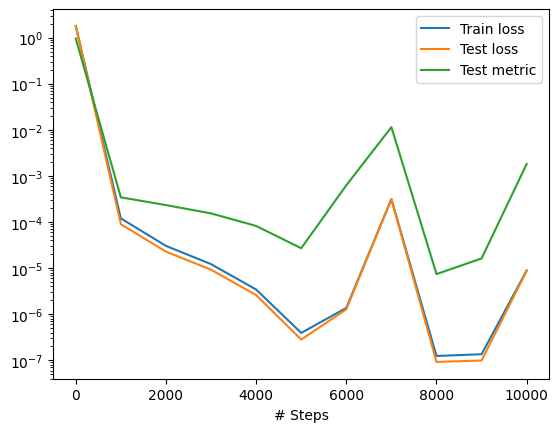

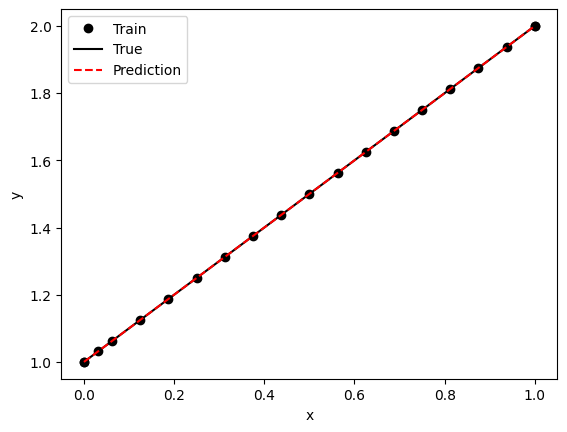

In [10]:
import deepxde as dde
import numpy as np

# solve Poisson equation in 1D
# 
# u_xx = 2, for -1 < x < 1
# 
# with Dirichlet boundary condition on the left boundary
# u(-1) = 0
# and Neumann boundary condition on the right boundary
# u_x(1) = 4
# 
# The exact solution is
# 
# u(x) = (x + 1)
# 
#######################
# NEW 
# solve Poisson equation in 1D
# 
# u_xx = 0, for 0 <= x <= 1
# 
# with Dirichlet boundary condition on the left boundary
# u(0) = 1
# and Neumann boundary condition on the right boundary
# u_x(1) = 2
# 
# The exact solution is
# 
# u(x) = (x + 1)
# 
#######################
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    #return dy_xx - 2
    return dy_xx - 0


def boundary_l(x, on_boundary):
    #return on_boundary and np.isclose(x[0], -1)
    return on_boundary and np.isclose(x[0], 0)


def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)


def func(x):
    #return (x + 1) ** 2
    return (x + 1)

# geom = dde.geometry.Interval(-1, 1)
geom = dde.geometry.Interval(0, 1)
bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)
#previous ode
#bc_r = dde.icbc.NeumannBC(geom, lambda X: 2 * (X + 1), boundary_r)
bc_r = dde.icbc.NeumannBC(geom, lambda X: 1, boundary_r)
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Problem 3
- How difficult do you think of this homework? Please give your marks between 1-5 (1 is the easiest and 5 is the most difficult).
- How difficult do you think of this lecture? Please give your marks between 1-5 (1 is the easiest and 5 is the most difficult).

I will try to adjust the lecture and homework based on your feedback.

homework - 1.5
lecture - 2.5

END OF CODE

### Use Machine Learning to solve Differential Equations

Physics-informed neural network is presented in more details in this paper: "DeepXDE: A deep learning library for solving differential equations" (https://arxiv.org/abs/1907.04502).

Solve the following ordinary differential equations for $u=u(x)$ with $0\le x\le 1$:
$$
\frac{d^2 u}{d x^2} = - 4\pi^2 \sin(2\pi x), \quad 0 \le x \le 1
$$
with Dirichlet boundary conditions:
$$
u(0) = 0, \quad u(1) = 0
$$

We can solve out the exact solution by hand:
$$
u(x) = \sin(2\pi x)
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn.functional as F

# feedforward neural network
class FNN(torch.nn.Module):
    def __init__(self, num=32):
        super(FNN, self).__init__()
        self.l1 = torch.nn.Linear(1, num)
        self.l2 = torch.nn.Linear(num, num)
        self.l3 = torch.nn.Linear(num, num)
        self.l4 = torch.nn.Linear(num, 1)

    def forward(self, x):
        z = F.tanh(self.l1(x))
        z = F.tanh(self.l2(z))
        z = F.tanh(self.l3(z))
        return self.l4(z)
    
    # compute the first-order derivative of u with respect to x    
    def dx(self, x):
        u = self.forward(x)
        vec_one = torch.ones(x.shape)
        ux = torch.autograd.grad(u, x, grad_outputs = vec_one, create_graph = True)[0]
        return ux

    # compute the second-order derivative of u with respect to x        
    def dxx(self, x):
        u = self.forward(x)
        vec_one = torch.ones(x.shape)
        ux = torch.autograd.grad(u, x, grad_outputs = vec_one, create_graph = True)[0]
        uxx = torch.autograd.grad(ux, x, grad_outputs = vec_one, create_graph = True)[0]
        return uxx

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 771.2973022460938
1000 0.7600846290588379
2000 0.010344401001930237
3000 0.002633915049955249
4000 0.0012189080007374287
5000 0.011379949748516083
6000 0.0005455928039737046
7000 0.00027266464894637465
8000 0.04023335501551628
9000 0.0006659249193035066


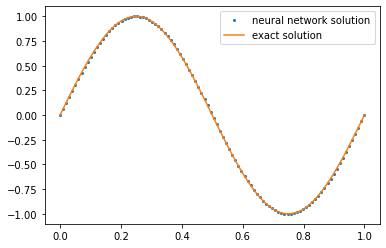

In [2]:
# solve u_xx = -4*pi^2*sin(x)
def source(x):
    return - 4 * math.pi**2 * torch.sin(2*math.pi*x)

# exact solution u = sin(2*pi*x)
def exact(x):
    return torch.sin(2*math.pi*x)

def dirichlet_bc(x_bc):
    return exact(x_bc)

# computational domain 0 < x < 1
Nx = 100
x = torch.linspace(0., 1., Nx, requires_grad=True)
x = torch.reshape(x, (Nx,1))

# boundary points
x_bd = torch.tensor([[0.], [1.]], requires_grad=True)

# neural network
model = FNN()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

total_epoch = 10000

for epoch in range(total_epoch):
    
    # set grad to be zero in the optimizer
    optimizer.zero_grad()
    
    # loss function
    loss = criterion(model.dxx(x), source(x)) + criterion(model(x_bd), dirichlet_bc(x_bd))

    loss.backward()
    optimizer.step()

    if epoch%1000 == 0:
        print(epoch, loss.item())    
        
# plot the solution from neural network and the exact solution
plt.figure()
plt.plot(x.detach(), model(x).detach(), 'o', markersize=2, label='neural network solution')
plt.plot(x.detach(), exact(x).detach(), '-', label='exact solution')
plt.legend()

plt.show()

## DeepXDE: a library for scientific machine learning and physics-informed learning

https://github.com/lululxvi/deepxde

In [3]:
%env DDE_BACKEND=pytorch

env: DDE_BACKEND=pytorch


In [6]:
!pip install deepxde


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 11.6 MB/s eta 0:00:00


### second-order ODE

Using backend: pytorch



Compiling model...
'compile' took 0.000266 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.05e-02, 1.00e+00, 3.84e+00]    [1.09e-02, 1.00e+00, 3.84e+00]    [9.98e-01]    
1000      [1.14e+00, 7.18e-01, 8.05e-01]    [9.85e-01, 7.18e-01, 8.05e-01]    [9.12e-01]    
2000      [8.95e-05, 7.85e-08, 1.61e-07]    [1.46e-04, 7.85e-08, 1.61e-07]    [6.68e-04]    
3000      [2.81e-05, 2.79e-12, 3.12e-07]    [5.40e-05, 2.79e-12, 3.12e-07]    [3.61e-04]    
4000      [2.63e-04, 4.30e-11, 5.85e-05]    [2.27e-04, 4.30e-11, 5.85e-05]    [8.15e-04]    
5000      [6.66e-06, 6.86e-11, 2.12e-08]    [2.68e-05, 6.86e-11, 2.12e-08]    [1.29e-04]    
6000      [6.49e-06, 2.18e-09, 6.46e-09]    [2.98e-05, 2.18e-09, 6.46e-09]    [5.10e-05]    
7000      [6.50e-06, 2.70e-09, 1.20e-09]    [3.03e-05, 2.70e-09, 1.20e-09]    [5.00e-05]    
8000      [7.46e-06, 2.15e-09, 4.88e-07]    [3.10e-05, 2.15e-09, 4.88e-07]    [1.24e-04]    
9000 

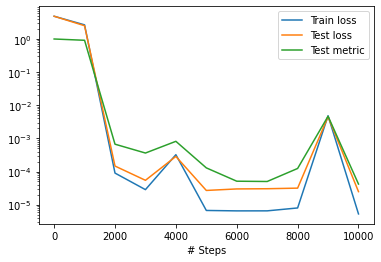

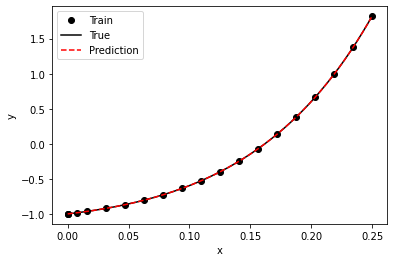

In [7]:
import deepxde as dde
import numpy as np

# solve second-order ODE for y = y(t)
# 
# y'' - 10 * y' + 9 * y = 5 * t
# 
# with initial condition
# 
# y(0) = -1
# y'(0) = 2

def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 - 10 * dy_dt + 9 * y - 5 * t


def func(t):
    return 50 / 81 + t * 5 / 9 - 2 * np.exp(t) + (31 / 81) * np.exp(9 * t)


geom = dde.geometry.TimeDomain(0, 0.25)


def boundary_l(t, on_initial):
    return on_initial and np.isclose(t[0], 0)


def bc_func1(inputs, outputs, X):
    return outputs + 1


def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - 2

# y(0) = -1
ic1 = dde.icbc.IC(geom, lambda x: -1, lambda _, on_initial: on_initial)
# y'(0) = 2
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

# number 16 is the number of training residual points sampled inside the domain
# number 2 is the number of training points sampled on the boundary
data = dde.data.TimePDE(geom, ode, [ic1, ic2], 16, 2, solution=func, num_test=500)
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[0.01, 1, 1])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### ODE system

Compiling model...
'compile' took 0.000637 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.23e+00, 3.64e-01, 0.00e+00, 1.00e+00]    [2.29e+00, 3.46e-01, 0.00e+00, 1.00e+00]    [1.91e+00]    
1000      [1.05e-02, 8.81e-03, 3.19e-08, 4.84e-04]    [1.19e-02, 8.74e-03, 3.19e-08, 4.84e-04]    [8.44e-01]    
2000      [6.59e-03, 4.77e-03, 3.12e-07, 1.66e-04]    [6.95e-03, 4.96e-03, 3.12e-07, 1.66e-04]    [6.66e-01]    
3000      [4.72e-03, 4.15e-03, 1.67e-06, 9.99e-05]    [4.87e-03, 4.38e-03, 1.67e-06, 9.99e-05]    [5.67e-01]    
4000      [2.86e-03, 3.53e-03, 3.05e-06, 7.24e-05]    [2.96e-03, 3.68e-03, 3.05e-06, 7.24e-05]    [4.56e-01]    
5000      [2.58e-03, 2.38e-03, 2.15e-04, 6.86e-05]    [2.65e-03, 1.97e-03, 2.15e-04, 6.86e-05]    [2.91e-01]    
6000      [2.01e-04, 2.55e-04, 1.86e-07, 2.11e-06]    [2.14e-04, 1.82e-04, 1.86e-07, 2.11e-06]    [9.02e-02]    
7000      [5.17e-05, 4.41e-05, 

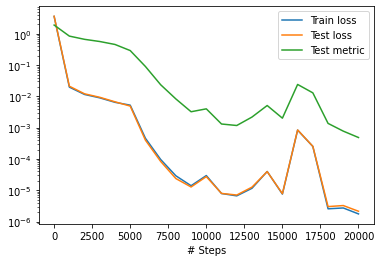

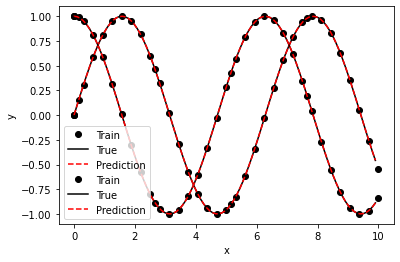

In [8]:
import deepxde as dde
import numpy as np


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    # the first dimension of y tensor is the training points
    # the second dimension o y tensor is the componets of the solution
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)

    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

# 0 < x < 10
geom = dde.geometry.TimeDomain(0, 10)
# y1(0) = 0
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
# y2(0) = 1
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Poisson equation

Compiling model...
'compile' took 0.000801 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.01e+00, 2.09e-02, 1.71e+01]    [4.00e+00, 2.09e-02, 1.71e+01]    [1.03e+00]    
1000      [6.16e-04, 4.58e-09, 3.38e-07]    [4.93e-04, 4.58e-09, 3.38e-07]    [5.37e-04]    
2000      [2.48e-04, 3.52e-10, 1.63e-08]    [2.09e-04, 3.52e-10, 1.63e-08]    [9.81e-04]    
3000      [4.07e-04, 5.84e-03, 2.30e-03]    [3.07e-04, 5.84e-03, 2.30e-03]    [2.54e-02]    
4000      [5.79e-05, 7.21e-07, 4.01e-07]    [4.44e-05, 7.21e-07, 4.01e-07]    [4.94e-04]    
5000      [3.71e-05, 7.67e-10, 5.39e-09]    [2.93e-05, 7.67e-10, 5.39e-09]    [2.29e-04]    
6000      [3.04e-05, 1.05e-05, 4.99e-06]    [2.66e-05, 1.05e-05, 4.99e-06]    [9.81e-04]    
7000      [2.90e-05, 7.64e-10, 2.32e-09]    [2.93e-05, 7.64e-10, 2.32e-09]    [5.02e-04]    
8000      [7.10e-05, 6.88e-04, 3.67e-04]    [6.12e-05, 6.88e-04, 3.67e-04]    [8.63e-03]    
9000 

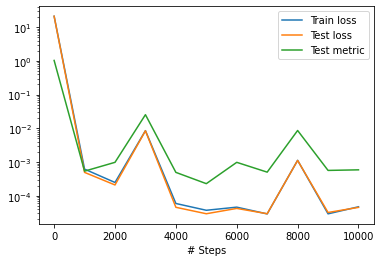

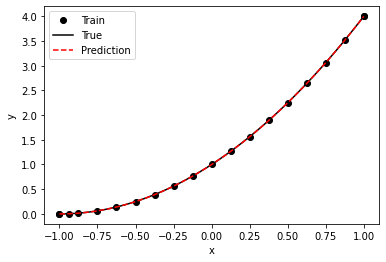

In [9]:
import deepxde as dde
import numpy as np

# solve Poisson equation in 1D
# 
# u_xx = 2, for -1 < x < 1
# 
# with Dirichlet boundary condition on the left boundary
# u(-1) = 0
# and Neumann boundary condition on the right boundary
# u_x(1) = 4
# 
# The exact solution is
# 
# u(x) = (x + 1)^2
# 
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - 2


def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)


def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)


def func(x):
    return (x + 1) ** 2


geom = dde.geometry.Interval(-1, 1)
bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)
bc_r = dde.icbc.NeumannBC(geom, lambda X: 2 * (X + 1), boundary_r)
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Heat equation

In [ ]:
import deepxde as dde
import numpy as np

# solve heat equation
# u_t = a * u_xx, 0 < x < 1 and 0 < t < 1
# 
# a is thermal diffusivity constant
# 
# with Dirichlet boundary condition
# u(0,t) = 0 and u(1,t) = 0
# 
# initial condition
# u(x,0) = sin(n*pi*x/L)
# L is the length of bar and n is the frequency of the sinusoidal initial conditions

def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()

# The first argument to pde is 2-dimensional vector 
# where the first component(x[:,0]) is x-coordinate and the second componenet (x[:,1]) is the t-coordinate
# The second argument is the network output, i.e., the solution u(x,t)
# but here we use y as the name of the variable
def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))